##### Last Updated: 10/30/2023

# Stock Prediction Deep Learning Model

##### Stock/Asset prices are time-series data and so I am implementing a LSTM (Long Short-Term Memory) which is a type of RNN (Recurrent Neural Network) that can remember information over a long period of time. 

In [1]:
# Copyright 2023 Shane Khalid. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [21]:
import yfinance as yf

import tensorflow as tf
from tensorflow import keras

from keras.layers import GRU, Dropout, SimpleRNN, LSTM, Dense, SimpleRNN, GRU
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used.")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead.")

import pandas as pd
import numpy as np

import plotly.express as px
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import math
import datetime
import keras
import warnings
warnings.filterwarnings('ignore')

from datetime import date, timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

from keras.metrics import Accuracy
from keras.metrics import F1Score
from keras.metrics import Precision


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import accuracy_score
#from sklearn.metrics import precision_score
#from sklearn.metrics import f1_score

%matplotlib inline

Num GPUs Available:  1
GPU is available and being used.


In [36]:
GRU_model = tf.keras.models.load_model('GRU.keras')

# Show the model architecture
GRU_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 165, 300)          272700    
                                                                 
 dropout (Dropout)           (None, 165, 300)          0         
                                                                 
 gru_1 (GRU)                 (None, 165, 100)          120600    
                                                                 
 dropout_1 (Dropout)         (None, 165, 100)          0         
                                                                 
 gru_2 (GRU)                 (None, 165, 100)          60600     
                                                                 
 dropout_2 (Dropout)         (None, 165, 100)          0         
                                                                 
 gru_3 (GRU)                 (None, 100)              

In [37]:
googl_df = yf.download("GOOGL", start="2010-01-01", end="2023-10-26")
googl_df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,15.689439,15.753504,15.621622,15.684434,15.684434,78169752
2010-01-05,15.695195,15.711712,15.554054,15.615365,15.615365,120067812
2010-01-06,15.662162,15.662162,15.174174,15.221722,15.221722,158988852
2010-01-07,15.250250,15.265265,14.831081,14.867367,14.867367,256315428
2010-01-08,14.814815,15.096346,14.742492,15.065566,15.065566,188783028
...,...,...,...,...,...,...
2023-10-19,138.500000,139.660004,137.380005,137.750000,137.750000,26066000
2023-10-20,137.330002,137.869995,135.080002,135.600006,135.600006,26315200
2023-10-23,135.039993,137.660004,133.949997,136.500000,136.500000,26317900


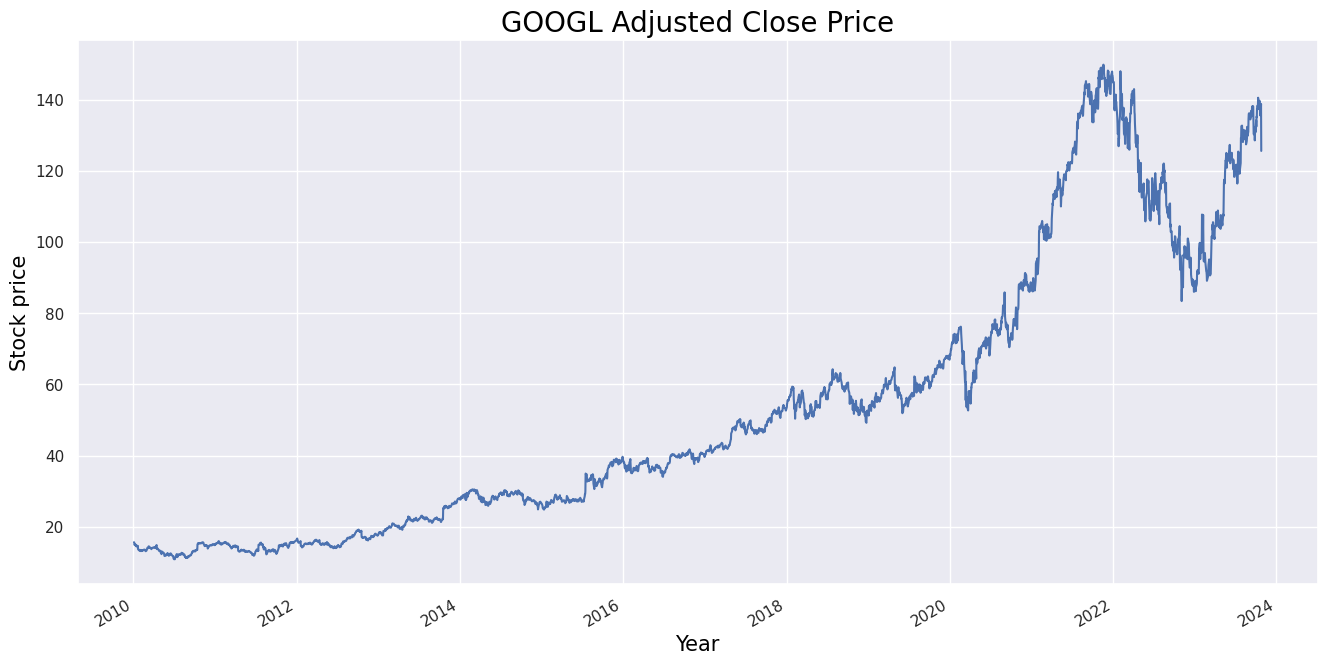

In [38]:
# Plot Adjusted Close price

googl_df['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(16, 8)})
plt.title('GOOGL Adjusted Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);

In [39]:
# create dataframe for adjusted closing price
googl_adj = googl_df[['Adj Close']]
googl_adj

,Adj Close
Date,
2010-01-04,15.684434
2010-01-05,15.615365
2010-01-06,15.221722
2010-01-07,14.867367
2010-01-08,15.065566
...,...
2023-10-19,137.750000
2023-10-20,135.600006
2023-10-23,136.500000


In [40]:
# Convert DataFrame to numpy array
googl_adj_arr = googl_adj.values

# Find number of rows to train model on (80% of data set) 
training_data_len = int(0.8*len(googl_adj))

training_data_len

2781

In [41]:
# Create train data set
train = googl_adj_arr[0:training_data_len, :]

In [42]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train)

train_scaled

array([[0.05742836],
       [0.05659711],
       [0.05185961],
       ...,
       [0.90826299],
       [0.94247261],
       [1.        ]])

In [43]:
train_scaled.shape

(2781, 1)

In [44]:
# Creating a data structure with 60 time-steps and 1 output

# Split data into X_train and y_train data sets
X_train = []
y_train = []
# Creating a data structure with 165 time-steps and 1 output
for i in range(165, len(train_scaled)):
    X_train.append(train_scaled[i-165:i, 0])
    y_train.append(train_scaled[i:i+1, 0])  
    if i <= 166:     # 165 days for first pass, 166 for second
      print(X_train)
      print(y_train)
      print()

[array([0.05742836, 0.05659711, 0.05185961, 0.04759494, 0.04998027,
       0.0497062 , 0.04650469, 0.0454837 , 0.04631495, 0.04334836,
       0.04564332, 0.04347183, 0.04424586, 0.03431607, 0.03130129,
       0.03203013, 0.03193375, 0.02958157, 0.02827145, 0.02919907,
       0.02862684, 0.03154825, 0.02731973, 0.02867804, 0.0293346 ,
       0.03022909, 0.02962976, 0.03021704, 0.02922919, 0.03169282,
       0.03076218, 0.03227108, 0.03153018, 0.03214458, 0.02981648,
       0.02873224, 0.02721432, 0.02732575, 0.02909969, 0.03162053,
       0.03290356, 0.03569545, 0.03859276, 0.03807173, 0.03738205,
       0.04227918, 0.0436917 , 0.04320981, 0.03828256, 0.03889094,
       0.03899937, 0.03925235, 0.03732482, 0.03657188, 0.03401188,
       0.03652067, 0.03819221, 0.03813498, 0.0380627 , 0.03934572,
       0.0394692 , 0.03997517, 0.04064078, 0.03980049, 0.03839099,
       0.03958063, 0.03919814, 0.04115881, 0.04538732, 0.04605895,
       0.04795635, 0.03435824, 0.03434317, 0.03583098, 0.0356

In [45]:
# Convert X_train and y_train to numpy arrays for training GRU model
X_train, y_train = np.array(X_train), np.array(y_train)

In [46]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [47]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(2616, 165, 1)


In [48]:
# Reshape the data as LSTM expects 3-D data (samples, time steps, features)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2616, 165, 1)

In [49]:
test = googl_adj_arr[training_data_len: , :]
test.shape

(696, 1)

In [50]:
inputs = googl_adj_arr[len(googl_adj_arr) - len(test) - 165:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [51]:
# Create data sets X_test and y_test

X_test = []
y_test = googl_adj_arr[training_data_len:, :]
for i in range(165,inputs.shape[0]):
    X_test.append(inputs[i-165:i,0])

In [52]:
# Convert df back to numpy array

X_test = np.array(X_test)

In [53]:
# Reshape data into 3D (because LSTM)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [54]:
print(X_test.shape)

(696, 165, 1)


### Make Predictions using the Test Set

In [55]:
# We want predictions to contain same values as y_test data set
GRU_predictions = GRU_model.predict(X_test)
GRU_predictions = scaler.inverse_transform(GRU_predictions)

 1/22 [>.............................] - ETA: 24s

2023-10-30 17:05:25.651856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


22/22 [==============================] - 2s 29ms/step


In [56]:
GRU_predictions.shape

(696, 1)

In [58]:
rmse = np.sqrt(np.mean(GRU_predictions - y_test)**2)  
rmse

75.665777250268

KeyError: 'GRU_predictions'

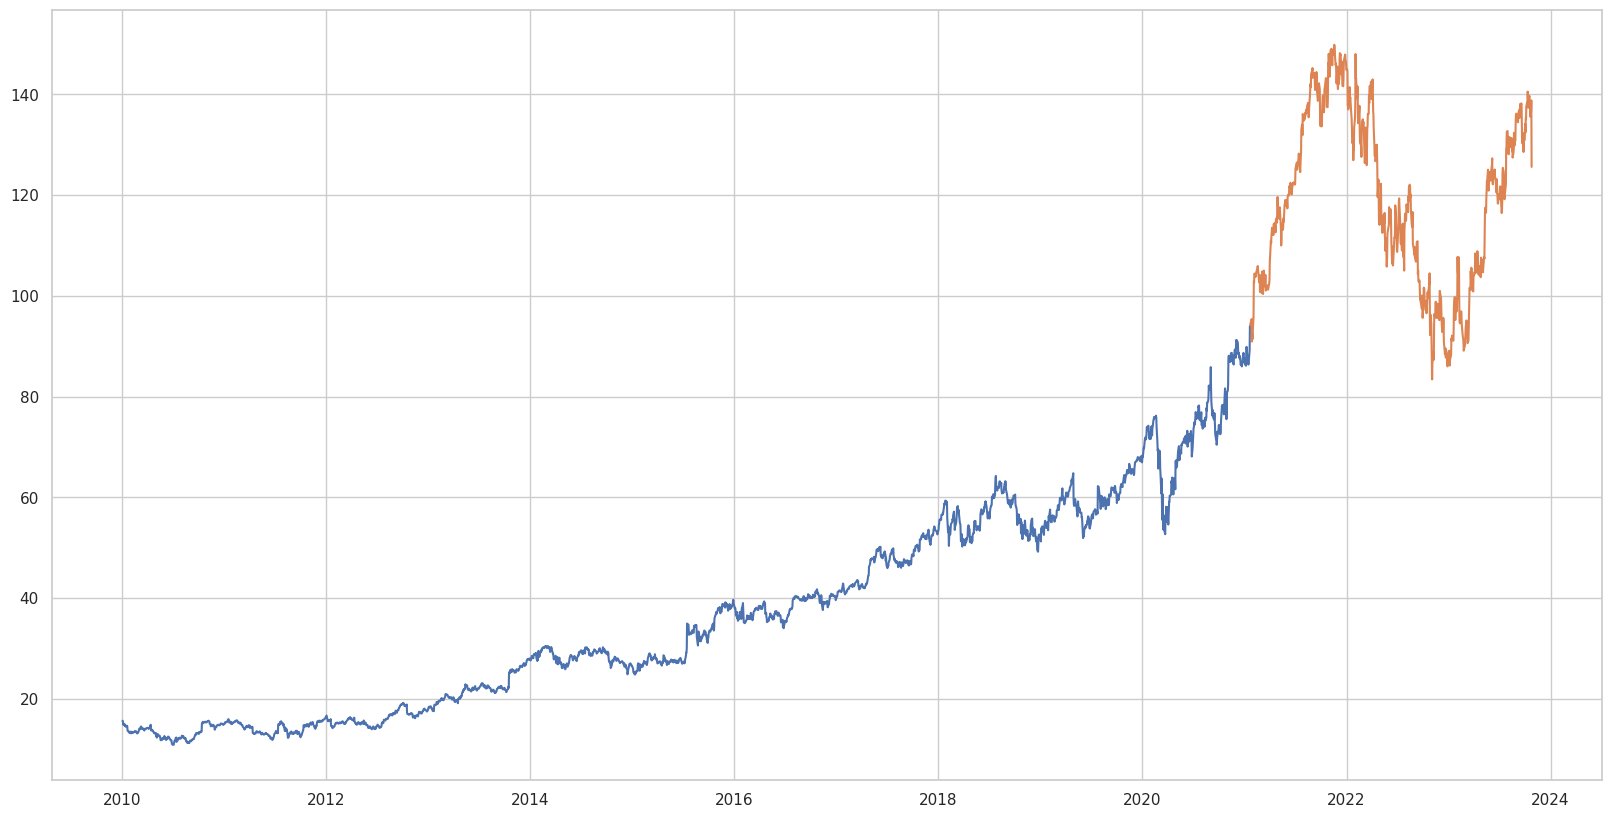

In [60]:
# Plot predicted vs actual values  
train = googl_adj[:training_data_len]
test = googl_adj[training_data_len:]
test['GRU_Predictions'] = GRU_predictions

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['GRU_predictions'], label='Predicted')
plt.title("GOOGL Close Price - GRU", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();

# Show the actual and predicted prices  
test

In [62]:
# Predict Adjusted Close price for GOOGL stock for October 27th 2023   
# get the quote
GOOGL_quote = yf.download("GOOGL", start="2015-07-10", end="2023-10-27")
# Create new df
new_df = GOOGL_quote.filter(['Adj Close'])
# Get last 165 days closing price and convert df to array])
last_165_days = new_df[-165:].values
# Scale data to be values between 0 and 1
last_165_days_scaled = scaler.transform(last_165_days)
# Create empty list
X_test = []
# Append last 165 days 
X_test.append(last_165_days_scaled)
# Convert the X_test data set to numpy array
X_test = np.array(X_test)
# Reshape data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get predicted price
pred_price = GRU_model.predict(X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 90ms/step
[[43.135536]]


In [63]:
# Actual price
GOOGL_quote2 = yf.download("GOOGL", start="2023-10-26", end="2023-10-27")
print(GOOGL_quote2['Adj Close'])

[*********************100%%**********************]  1 of 1 completed
Date
2023-10-26    122.279999
Name: Adj Close, dtype: float64


### Not even close. Let's do LSTM